# Injury Severity Based on Physical Factors

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Data Loading and Preprocssing

In [2]:
# Merge the InjuryRecord and PlayList csv files
injury_record = pd.read_csv("data/InjuryRecord.csv")
play_list = pd.read_csv("data/PlayList.csv")

merged_df = pd.merge(play_list, injury_record, on=['PlayerKey', 'GameID'], how='left')
merged_df.head()

,PlayerKey,GameID,PlayKey_x,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,...,PlayerGamePlay,Position,PositionGroup,PlayKey_y,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,...,1,QB,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,...,2,QB,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,...,3,QB,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,...,4,QB,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,...,5,QB,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Drop useless columns
# print(merged_df.nunique("PlayerKey"))
merged_df = merged_df.drop(["PlayerKey", "GameID", "PlayerGamePlay", "Position", "RosterPosition", "PlayerDay", "PlayerGame", "Surface", "PlayKey_x", "PlayKey_y"], axis=1)
merged_df.to_csv('mergedData.csv', index=False)
merged_df.head()

,StadiumType,FieldType,Temperature,Weather,PlayType,PositionGroup,BodyPart,DM_M1,DM_M7,DM_M28,DM_M42
0,Outdoor,Synthetic,63,Clear and warm,Pass,QB,NaN,NaN,NaN,NaN,NaN
1,Outdoor,Synthetic,63,Clear and warm,Pass,QB,NaN,NaN,NaN,NaN,NaN
2,Outdoor,Synthetic,63,Clear and warm,Rush,QB,NaN,NaN,NaN,NaN,NaN
3,Outdoor,Synthetic,63,Clear and warm,Rush,QB,NaN,NaN,NaN,NaN,NaN
4,Outdoor,Synthetic,63,Clear and warm,Pass,QB,NaN,NaN,NaN,NaN,NaN


In [4]:
# Clean up columns and dummy encode where necessary

# StadiumType cleaning and dummy encode
merged_df = merged_df.dropna(subset=['StadiumType'])
merged_df.drop(merged_df[merged_df['StadiumType'].isin(['Cloudy', 'Bowl', 'Heinz Field'])].index, inplace=True)
merged_df['StadiumType'] = merged_df['StadiumType'].apply(lambda x: 'Outdoor' if 'ou' in str(x).lower() else x)
merged_df['StadiumType'] = merged_df['StadiumType'].apply(lambda x: 'Retractable Roof' if ('clos' in str(x).lower() or 'open' in str(x).lower() or 'dome' in str(x).lower()) and str(x).lower() != 'Open' else x)
merged_df['StadiumType'] = merged_df['StadiumType'].apply(lambda x: 'Indoors' if 'ind' in str(x).lower() else x)
merged_df = pd.get_dummies(merged_df, columns=['StadiumType'], prefix='StadiumType')

# FieldType dummy encode
merged_df = pd.get_dummies(merged_df, columns=['FieldType'], prefix='FieldType')

# Temperature cleaning
merged_df.drop(merged_df[merged_df['Temperature'] == -999].index, inplace=True)

# Weather cleaning and dummy encode
merged_df = merged_df.dropna(subset=['Weather'])
merged_df.drop(merged_df[merged_df['Weather'].isin(['Cold', 'Hazy', 'Heat Index 95'])].index, inplace=True)
merged_df['Weather'] = merged_df['Weather'].apply(lambda x: 'Sunny' if 'sun' in str(x).lower() else x)
merged_df['Weather'] = merged_df['Weather'].apply(lambda x: 'Rain' if ('rain' in str(x).lower() or 'shower' in str(x).lower()) else x)
merged_df['Weather'] = merged_df['Weather'].apply(lambda x: 'Clear' if ('clear' in str(x).lower() or 'fair' in str(x).lower()) else x)
merged_df['Weather'] = merged_df['Weather'].apply(lambda x: 'Cloudy' if 'dy' in str(x).lower() else x)
merged_df['Weather'] = merged_df['Weather'].apply(lambda x: 'Indoors' if ('indo' in str(x).lower() or 'climate' in str(x).lower()) else x)
merged_df['Weather'] = merged_df['Weather'].apply(lambda x: 'Snow' if 'snow' in str(x).lower() else x)
merged_df = pd.get_dummies(merged_df, columns=['Weather'], prefix='Weather')

# PlayType cleaning and dummy encode
merged_df = merged_df.dropna(subset=['PlayType'])
merged_df.drop(merged_df[merged_df['PlayType'] == '0'].index, inplace=True)
merged_df = pd.get_dummies(merged_df, columns=['PlayType'], prefix='PlayType')

# PositionGroup cleaning and dummy encode
merged_df.drop(merged_df[merged_df['PositionGroup'] == 'Missing Data'].index, inplace=True)
merged_df = pd.get_dummies(merged_df, columns=['PositionGroup'], prefix='PositionGroup')

# BodyPart cleaning and dummy encode
merged_df['BodyPart'].fillna('None', inplace=True)
merged_df = pd.get_dummies(merged_df, columns=['BodyPart'], prefix='BodyPart')

# DM_M1
merged_df['DM_M1'].fillna(0.0, inplace=True)

# DM_M7
merged_df['DM_M7'].fillna(0.0, inplace=True)

# DM_M28
merged_df['DM_M28'].fillna(0.0, inplace=True)

# DM_M42
merged_df['DM_M42'].fillna(0.0, inplace=True)

# Drop duplicate rows
merged_df = merged_df.drop_duplicates()

# Ouput to file to verify
merged_df.to_csv('mergedData.csv', index=False)
merged_df.head()

/tmp/ipykernel_19252/3896484156.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['BodyPart'].fillna('None', inplace=True)
/tmp/ipykernel_19252/3896484156.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

,Temperature,DM_M1,DM_M7,DM_M28,DM_M42,StadiumType_Indoors,StadiumType_Outdoor,StadiumType_Retractable Roof,FieldType_Natural,FieldType_Synthetic,...,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR,BodyPart_Ankle,BodyPart_Foot,BodyPart_Heel,BodyPart_Knee,BodyPart_None,BodyPart_Toes
0,63,0.0,0.0,0.0,0.0,False,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False
2,63,0.0,0.0,0.0,0.0,False,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False
81,85,0.0,0.0,0.0,0.0,True,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
82,85,0.0,0.0,0.0,0.0,True,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
157,84,0.0,0.0,0.0,0.0,False,True,False,False,True,...,False,False,False,False,False,False,False,False,True,False


# Remove All Data Where an Injury Doesn't Occur

In [5]:
# Remove injury-less data; I should've done it earlier but this was an afterthought, and I'm lazy
merged_df = merged_df[merged_df["DM_M1"] != 0.0]
merged_df.to_csv('mergedDataNoInjury.csv', index=False)
merged_df.head()

,Temperature,DM_M1,DM_M7,DM_M28,DM_M42,StadiumType_Indoors,StadiumType_Outdoor,StadiumType_Retractable Roof,FieldType_Natural,FieldType_Synthetic,...,PositionGroup_RB,PositionGroup_SPEC,PositionGroup_TE,PositionGroup_WR,BodyPart_Ankle,BodyPart_Foot,BodyPart_Heel,BodyPart_Knee,BodyPart_None,BodyPart_Toes
7255,89,1.0,1.0,1.0,1.0,False,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
7256,89,1.0,1.0,1.0,1.0,False,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
7258,89,1.0,1.0,1.0,1.0,False,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
9491,84,1.0,0.0,0.0,0.0,True,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
9495,84,1.0,0.0,0.0,0.0,True,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False


# Split Data

In [6]:
y = merged_df['DM_M28']
X = merged_df.drop(['DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model (RandomForest)

In [7]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1': 'f1',
    'recall': 'recall',
}

# Define the parameter grid for tuning Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],                  # Depth of each tree
    'min_samples_split': [2, 5, 10],                      # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],                        # Minimum samples per leaf node
    'max_features': ['sqrt', 'log2', None]                # Features considered for the best split
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring=scoring,  
    cv=3,          
    n_jobs=-1,     
    refit='f1',
)

# Perform the grid search
grid_search_rf.fit(X_train, y_train)

# Best parameters and model
best_model_rf = grid_search_rf.best_estimator_
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Make predictions using the best model
y_pred_rf = best_model_rf.predict(X_test)

# Calculate evaluation metrics
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='binary')  
f1_rf = f1_score(y_test, y_pred_rf, average='binary')    
recall_rf = recall_score(y_test, y_pred_rf, average='binary')

# Display results
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"F1-Score: {f1_rf}")
print(f"Recall: {recall_rf}\n")

# Confusion Matrix
print("Confusion Matrix:\n", conf_matrix_rf)

Best Parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Accuracy: 0.9056603773584906
Precision: 0.8
F1-Score: 0.8275862068965518
Recall: 0.8571428571428571

Confusion Matrix:
 [[36  3]
 [ 2 12]]


# Feature Importance Graph

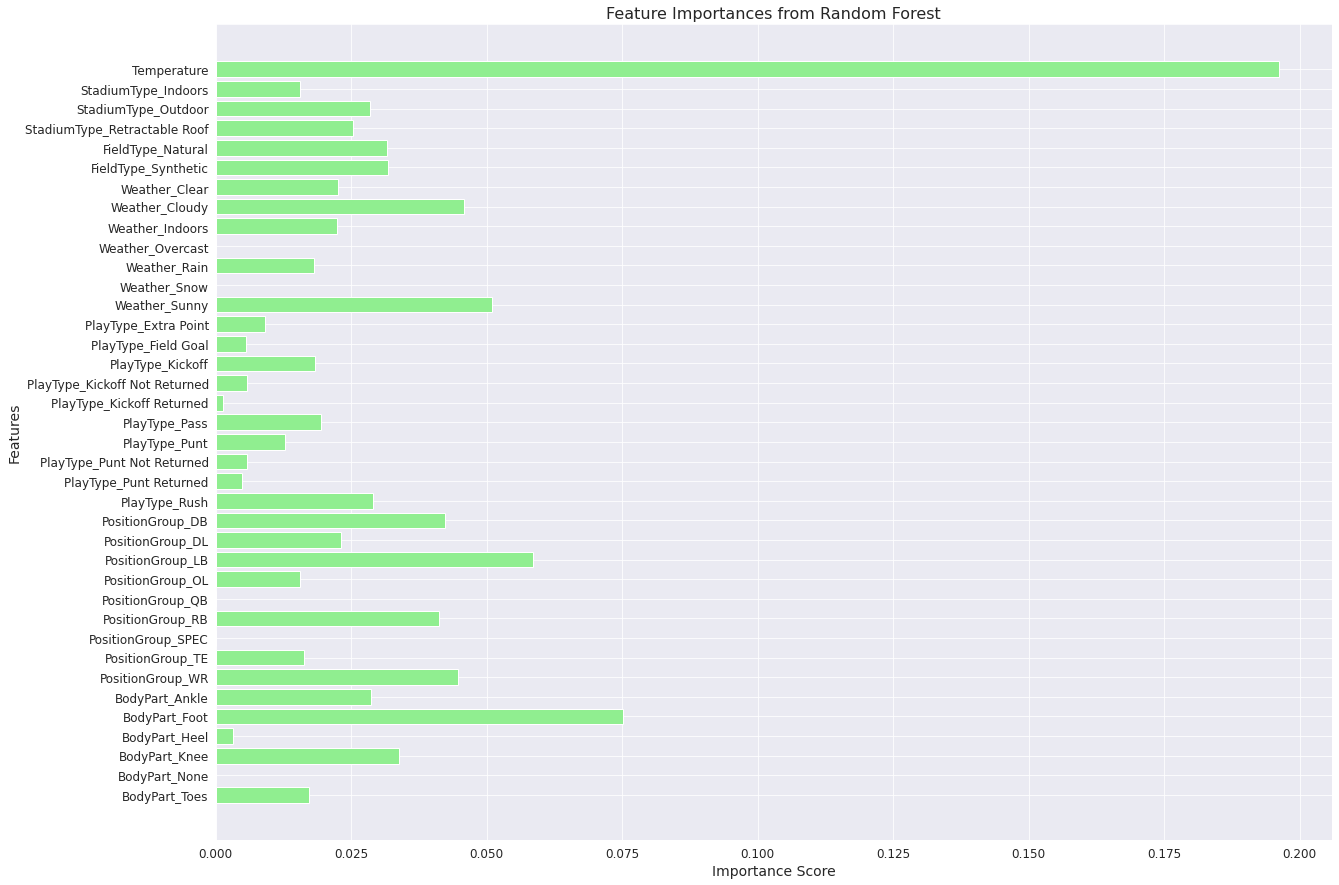

In [8]:
# Feature importance graph
feature_importances = best_model_rf.feature_importances_
features = X.columns

# Feature importance graph
plt.figure(figsize=(20, 15))  # Increase size (width=12, height=10)
plt.barh(features, feature_importances, color='lightgreen')
plt.title("Feature Importances from Random Forest", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Logistic Regression

In [9]:
# Scale the features
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)

# Define the parameter grid for tuning
param_grid_LR = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Regularization types
    'solver': ['liblinear', 'saga']  # Solvers
}

# Initialize the logistic regression model
logreg_LR = LogisticRegression(max_iter=2000)

# Perform Grid Search
grid_search_LR = GridSearchCV(
    logreg_LR,
    param_grid_LR,
    cv=3,
    scoring=scoring,
    refit='f1',
    n_jobs=-1
)
grid_search_LR.fit(X_scaled_train, y_train)

# Best parameters and model
best_model_LR = grid_search_LR.best_estimator_
print("Best Parameters:", grid_search_LR.best_params_)

# Make predictions on the test set
y_pred_LR = best_model_LR.predict(X_scaled_test)

# Calculate metrics
accuracy_LR = accuracy_score(y_test, y_pred_LR)
precision_LR = precision_score(y_test, y_pred_LR, average='binary')  # Adjust `average` for multiclass
f1_LR = f1_score(y_test, y_pred_LR, average='binary')  # Adjust `average` for multiclass
recall_LR = recall_score(y_test, y_pred_LR, average='binary')

# Print the results
print(f"Accuracy: {accuracy_LR}")
print(f"Precision: {precision_LR}")
print(f"F1-score: {f1_LR}")
print(f"Recall: {recall_LR}")

# Confusion Matrix
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)
print("\nConfusion Matrix:")
print(conf_matrix_LR)

Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.7735849056603774
Precision: 0.5833333333333334
F1-score: 0.5384615384615384
Recall: 0.5

Confusion Matrix:
[[34  5]
 [ 7  7]]


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

# MLP

In [10]:
# Define the parameter grid
param_grid_MLP = {
    'hidden_layer_sizes': [
        (10),
        (100,),
        (100, 50),
        (120, 80, 40), 
        (100, 80, 60, 40, 20),
        (150, 120, 90, 60, 30)
    ],
    'activation': ['relu'],          # Test different activation functions
    'solver': ['adam', 'sgd'],                   # Include stochastic gradient descent
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],    # Regularization strength
    'learning_rate': ['adaptive', 'constant'],   # Test learning rate schedules
}

# Define the base MLPClassifier
mlp_MLP = MLPClassifier(early_stopping=True, random_state=42, max_iter=1000)

# Set up GridSearchCV
grid_search_MLP = GridSearchCV(
    estimator=mlp_MLP,
    param_grid=param_grid_MLP,
    scoring=scoring,  
    cv=3,
    refit='f1',
    n_jobs=-1
)

# Perform the grid search
grid_search_MLP.fit(X_scaled_train, y_train)

# Best parameters and model
best_model_MLP = grid_search_MLP.best_estimator_
print("Best Parameters:", grid_search_MLP.best_params_)

# Make predictions on the test set
y_pred_MLP = best_model_MLP.predict(X_scaled_test)

# Evaluate the model
accuracy_MLP = accuracy_score(y_test, y_pred_MLP)
precision_MLP = precision_score(y_test, y_pred_MLP, average='binary')  # Adjust `average` for multiclass
f1_MLP = f1_score(y_test, y_pred_MLP, average='binary')  # Adjust `average` for multiclass
recall_MLP = recall_score(y_test, y_pred_MLP, average='binary')

# Print classification metrics
print(f"\nAccuracy: {accuracy_MLP:}")
print(f"Precision: {precision_MLP:}")
print(f"F1-score: {f1_MLP:}")
print(f"Recall: {recall_MLP}")

# Confusion Matrix
conf_matrix_MLP = confusion_matrix(y_test, y_pred_MLP)
print("\nConfusion Matrix:")
print(conf_matrix_MLP)

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}

Accuracy: 0.32075471698113206
Precision: 0.25
F1-score: 0.37931034482758624
Recall: 0.7857142857142857

Confusion Matrix:
[[ 6 33]
 [ 3 11]]


# SVM

In [11]:
# Define the parameter grid for SVM
param_grid_SVM = {
    'C': [0.01, 0.1, 1, 10, 100],           # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],    # Kernel types
    'gamma': ['scale', 'auto'],             # Kernel coefficient
    'degree': [2, 3, 4]                     # Degree for polynomial kernel
}

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)  # Enable probability=True for predict_proba

# Set up GridSearchCV
grid_search_SVM = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_SVM,
    scoring=scoring,  # Optimize for F1-score
    cv=3,
    n_jobs=-1,
    refit='f1'
)

# Perform the grid search
grid_search_SVM.fit(X_scaled_train, y_train)

# Best parameters and model
best_model_SVM = grid_search_SVM.best_estimator_
print("Best Parameters:", grid_search_SVM.best_params_)

# Make predictions on the test set
y_pred_SVM = best_model_SVM.predict(X_scaled_test)

# Evaluate the model
accuracy_SVM = accuracy_score(y_test, y_pred_SVM)
precision_SVM = precision_score(y_test, y_pred_SVM, average='binary')  # Adjust for multiclass if needed
f1_SVM = f1_score(y_test, y_pred_SVM, average='binary')                # Adjust for multiclass if needed
recall_SVM = recall_score(y_test, y_pred_SVM, average='binary')
conf_matrix_SVM = confusion_matrix(y_test, y_pred_SVM)

# Print classification metrics
print(f"\nAccuracy: {accuracy_SVM:}")
print(f"Precision: {precision_SVM:}")
print(f"F1-score:  {f1_SVM:}")
print(f"Recall:    {recall_SVM}")
print("\nConfusion Matrix:")
print(conf_matrix_SVM)

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

Best Parameters: {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Accuracy: 0.8301886792452831
Precision: 0.6666666666666666
F1-score:  0.689655172413793
Recall:    0.7142857142857143

Confusion Matrix:
[[34  5]
 [ 4 10]]


# Comparison Graph

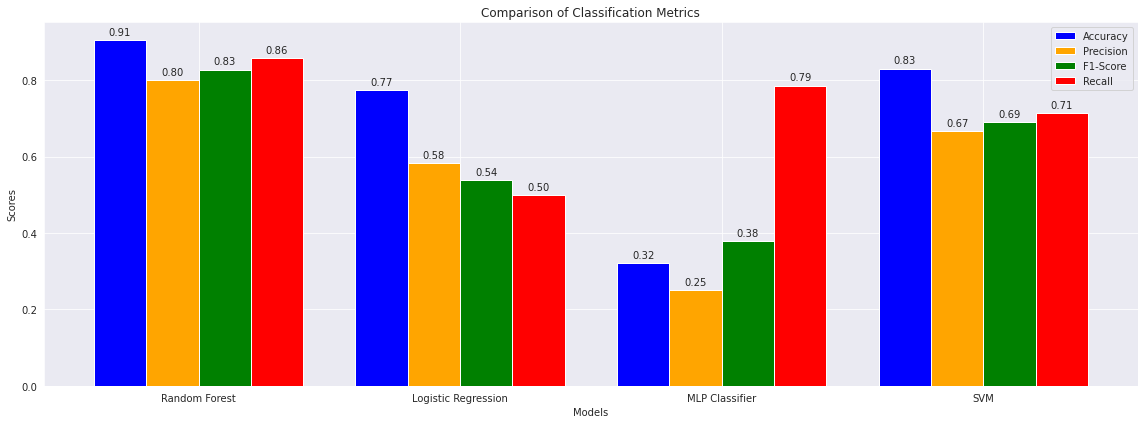

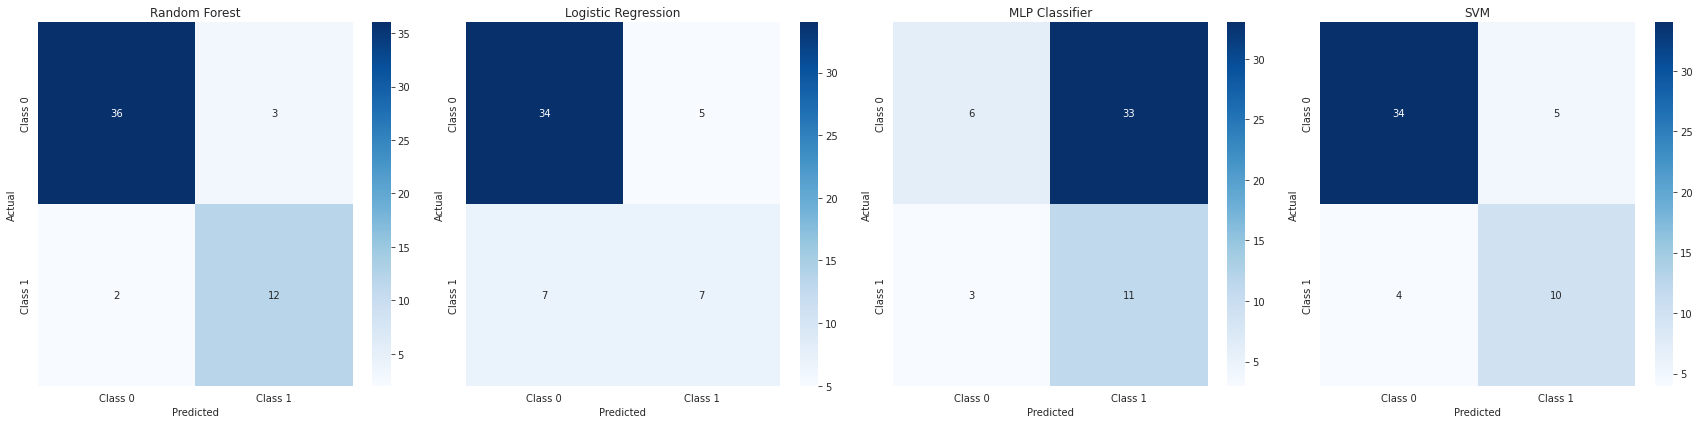

In [18]:
conf_matrices = [conf_matrix_rf, conf_matrix_LR, conf_matrix_MLP, conf_matrix_SVM]
models = ['Random Forest', 'Logistic Regression', 'MLP Classifier', 'SVM']

# Classification Metrics
accuracy_scores = [accuracy_rf, accuracy_LR, accuracy_MLP, accuracy_SVM]
precision_scores = [precision_rf, precision_LR, precision_MLP, precision_SVM]
f1_scores = [f1_rf, f1_LR, f1_MLP, f1_SVM]
recall_scores = [recall_rf, recall_LR, recall_MLP, recall_SVM]  # Added recall scores

# Plot Classification Metrics
fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(len(models))  # Label locations
width = 0.2  # Adjust width for 4 metrics

# Classification Metrics
bar1 = ax.bar(x - width*1.5, accuracy_scores, width, label='Accuracy', color='blue')
bar2 = ax.bar(x - width/2, precision_scores, width, label='Precision', color='orange')
bar3 = ax.bar(x + width/2, f1_scores, width, label='F1-Score', color='green')
bar4 = ax.bar(x + width*1.5, recall_scores, width, label='Recall', color='red')  # Added recall bars

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classification Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Annotate bar heights
for bars in [bar1, bar2, bar3, bar4]:  # Include recall bars
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):  # Skip NaN values
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset for text
                        textcoords="offset points",
                        ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for ax, conf_matrix, model_name in zip(axes, conf_matrices, models):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], ax=ax)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()
